<a href="https://colab.research.google.com/github/manavraj01/New-York-Fare-Price-Prediction/blob/first/New_York_Taxi_Fare_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install  Required Libraries

In [ ]:
!pip install numpy pandas matplotlib seaborn scikit-learn xgboost opendatasets graphviz --quiet

Download and Import the dataset

In [ ]:
dataset_url = "https://www.kaggle.com/competitions/new-york-city-taxi-fare-prediction/"

In [ ]:
import opendatasets as od
od.download(dataset_url)

100%|██████████| 1.56G/1.56G [00:11<00:00, 140MB/s]



Extracting archive ./new-york-city-taxi-fare-prediction/new-york-city-taxi-fare-prediction.zip to ./new-york-city-taxi-fare-prediction


In [ ]:
import os
data_dir = 'new-york-city-taxi-fare-prediction'

List the files and their sizes

In [ ]:
!ls -lh {data_dir}

total 5.4G
-rw-r--r-- 1 root root  486 Sep 20 04:40 GCP-Coupons-Instructions.rtf
-rw-r--r-- 1 root root 336K Sep 20 04:40 sample_submission.csv
-rw-r--r-- 1 root root 960K Sep 20 04:40 test.csv
-rw-r--r-- 1 root root 5.4G Sep 20 04:42 train.csv


Number of lines in dataset

In [ ]:
!wc -l {data_dir}/train.csv

55423856 new-york-city-taxi-fare-prediction/train.csv


In [ ]:
!head {data_dir}/train.csv

key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.84161,40.712278,1
2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.76127,-73.991242,40.750562,2
2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.98713,40.733143,-73.991567,40.758092,1
2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1
2011-01-06 09:50:45.0000002,12.1,2011-01-06 09:50:45 UTC,-74.000964,40.73163,-73.972892,40.758233,1
2012-11-20 20:35:00.0000001,7.5,2012-11-20 20:35:00 UTC,-73.980002,40.751662,-73.973802,40.764842,1
2012-01-04 17:22:00.00000081,16.5,2012-01-04 17:22:00 UTC,-73.9513,40.774138,-73.990095,40.751048,1
2012-12-03 13:10:00.000000125,9,2012-12-03 13:10:00 UTC,-74.006462,40.726713,-73.99

Observations:

- This is a supervised learning regression problem
- Training data is 5.5 GB in size
- Training data has 5.5 million rows
- Test set is much smaller (< 10,000 rows)
- The training set has 8 columns:
    - `key` (a unique identifier)
    - `fare_amount` (target column)
    - `pickup_datetime`
    - `pickup_longitude`
    - `pickup_latitude`
    - `dropoff_longitude`
    - `dropoff_latitude`
    - `passenger_count`
- The test set has all columns except the target column `fare_amount`.
- The submission file should contain the `key` and `fare_amount` for each test sample.


### Loading Training Set

Loading the entire dataset into Pandas is going to be slow, so we can use the following optimizations:

- Ignore the `key` column
- Parse pickup datetime while loading data
- Specify data types for other columns
   - `float32` for geo coordinates
   - `float32` for fare amount
   - `uint8` for passenger count
- Work with a 1% sample of the data (~500k rows)

We can apply these optimizations while using [`pd.read_csv`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html)

In [ ]:
import pandas as pd
import random as  rd
train_dataset = f"{data_dir}/train.csv"
dtypes = {
    "fare_amount": "float32",
    "pickup_longitude": "float32",
    "pickup_latitude": "float32",
    "dropoff_longitude": "float32",
    "dropoff_latitude": "float32",
    "passenger_count":"uint8"
}

selected_columns = "fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count".split(',')

rd.seed(42)
sample_size = 0.01
def skipRow(row_idx):
  if row_idx == 0:
    return False
  return rd.random() > sample_size


train_df  = pd.read_csv(train_dataset , dtype= dtypes ,parse_dates=["pickup_datetime"],usecols=selected_columns,skiprows=skipRow)

In [ ]:
train_df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.0,2014-12-06 20:36:22+00:00,-73.979813,40.751904,-73.979446,40.755482,1
1,8.0,2013-01-17 17:22:00+00:00,0.000000,0.000000,0.000000,0.000000,2
2,8.9,2011-06-15 18:07:00+00:00,-73.996330,40.753223,-73.978897,40.766964,3
3,6.9,2009-12-14 12:33:00+00:00,-73.982430,40.745747,-73.982430,40.745747,1
4,7.0,2013-11-06 11:26:54+00:00,-73.959061,40.781059,-73.962059,40.768604,1


Loading Test Dataset

In [ ]:
test_dir = f"{data_dir}/test.csv"
test_df = pd.read_csv(test_dir , dtype = dtypes,parse_dates=["pickup_datetime"])

test_df.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44+00:00,-73.982521,40.751259,-73.979652,40.746140,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12+00:00,-73.981163,40.767807,-73.990448,40.751637,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12+00:00,-73.966049,40.789776,-73.988564,40.744427,1


Exploring Dataset

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 552450 entries, 0 to 552449
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   fare_amount        552450 non-null  float32            
 1   pickup_datetime    552450 non-null  datetime64[ns, UTC]
 2   pickup_longitude   552450 non-null  float32            
 3   pickup_latitude    552450 non-null  float32            
 4   dropoff_longitude  552450 non-null  float32            
 5   dropoff_latitude   552450 non-null  float32            
 6   passenger_count    552450 non-null  uint8              
dtypes: datetime64[ns, UTC](1), float32(5), uint8(1)
memory usage: 15.3 MB


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   key                9914 non-null   object             
 1   pickup_datetime    9914 non-null   datetime64[ns, UTC]
 2   pickup_longitude   9914 non-null   float32            
 3   pickup_latitude    9914 non-null   float32            
 4   dropoff_longitude  9914 non-null   float32            
 5   dropoff_latitude   9914 non-null   float32            
 6   passenger_count    9914 non-null   uint8              
dtypes: datetime64[ns, UTC](1), float32(4), object(1), uint8(1)
memory usage: 319.6+ KB


In [ ]:
train_df.duplicated().sum()

np.int64(0)

In [ ]:
test_df.duplicated().sum()

np.int64(0)

In [ ]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
fare_amount,552450.0,11.354059,9.810809,-52.000000,6.000000,8.500000,12.500000,499.000000
pickup_longitude,552450.0,-72.497063,11.622035,-1183.362793,-73.992020,-73.981819,-73.967155,2420.209473
pickup_latitude,552450.0,39.910500,8.041162,-3084.490234,40.734875,40.752621,40.767036,404.983337
dropoff_longitude,552450.0,-72.504326,12.065184,-3356.729736,-73.991425,-73.980179,-73.963737,2467.752686
dropoff_latitude,552450.0,39.934265,9.226158,-2073.150635,40.733990,40.753101,40.768059,3351.403076
passenger_count,552450.0,1.684983,1.337664,0.000000,1.000000,1.000000,2.000000,208.000000


## 3. Prepare Dataset for Training

- Split Training & Validation Set
- Fill/Remove Missing Values
- Extract Inputs & Outputs
   - Training
   - Validation
   - Test

In [ ]:
from sklearn.model_selection import train_test_split
train_df,val_df = train_test_split(train_df,test_size = 0.2,random_state=42)

len(train_df),len(val_df)

(441960, 110490)

Remove Null Values

In [ ]:
train_df = train_df.dropna()
test_df = test_df.dropna()

Input and Output Columns

In [ ]:
columns = train_df.columns

In [ ]:
columns
target_cols = 'fare_amount'

input_cols = columns.drop(target_cols)


In [ ]:
train_inputs = train_df[input_cols]
#train_inputs = train_df.drop(columns = ['pickup_datetime'])
train_outputs = train_df[target_cols]

val_inputs = val_df[input_cols]
val_outputs = val_df[target_cols]

test_inputs = test_df[input_cols]

## 4. Train Hardcoded & Baseline Models

- Hardcoded model: always predict average fare
- Baseline model: Linear regression

For evaluation the dataset uses RMSE error:
https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/overview/evaluation

In [ ]:
import numpy as np

In [ ]:
class MeanRegressor():
  def fit(self,inputs,targets):
    self.mean = targets.mean()

  def predict(self,targets):
    return np.full(targets.shape,self.mean)

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
mean_model = MeanRegressor()
mean_model.fit(train_inputs,train_outputs)

mean_pred = mean_model.predict(train_outputs)
mean_rmse = mean_squared_error(train_outputs,mean_pred)
print(f"Train RMSE: {mean_rmse}")

Train RMSE: 95.83982849121094


In [ ]:
val_pred = mean_model.predict(val_outputs)
val_rmse = mean_squared_error(val_outputs,val_pred)
print(f"Validation RMSE: {val_rmse}")

Validation RMSE: 98.00909423828125


### Train & Evaluate Baseline Model

We'll traina linear regression model as our baseline, which tries to express the target as a weighted sum of the inputs.

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
linear_model = LinearRegression()

train_inputs = train_inputs.drop(columns= ["pickup_datetime"])
linear_model.fit(train_inputs,train_outputs)

linear_model_preds = linear_model.predict(train_inputs)
linear_model_rmse = mean_squared_error(train_outputs,linear_model_preds)
print(f"Train RMSE: {linear_model_rmse}")

Train RMSE: 95.81732940673828


In [ ]:
val_inputs = val_inputs.drop(columns= ["pickup_datetime"])
linear_model_val_preds = linear_model.predict(val_inputs)
linear_model_val_rmse = mean_squared_error(val_outputs,linear_model_val_preds)
print(f"Validation RMSE: {linear_model_val_rmse}")

Validation RMSE: 97.97215270996094


## 5. Make Predictions and Submit to Kaggle

- Make predictions for test set
- Generate submissions CSV
- Submit to Kaggle
- Record in experiment tracking sheet

In [ ]:
test_inputs = test_inputs.drop(columns= ["pickup_datetime"])
test_preds = linear_model.predict(test_inputs)

In [ ]:
submission_df = pd.read_csv(data_dir+"/sample_submission.csv")
submission_df.head()

,key,fare_amount
0,2015-01-27 13:08:24.0000002,11.35
1,2015-01-27 13:08:24.0000003,11.35
2,2011-10-08 11:53:44.0000002,11.35
3,2012-12-01 21:12:12.0000002,11.35
4,2012-12-01 21:12:12.0000003,11.35


In [ ]:
def generateSubmissionFile(test_preds,fname):
  sub_df  = pd.read_csv(data_dir+'/sample_submission.csv')
  sub_df['fare_amount'] = test_preds
  sub_df.to_csv(fname,index=False)

In [ ]:
generateSubmissionFile(test_preds,"submission.csv")

## 6. Feature Engineering


- Extract parts of date
- Remove outliers & invalid data
- Add distance between pickup & drop
- Add distance from landmarks

Exercise: We're going to apply all of the above together, but you should observer the effect of adding each feature individually.

In [ ]:
def addDateYear(df,col):
  pickup = "pickup"
  df[pickup+"_year"]=df[col].dt.year
  df[pickup+"_month"]=df[col].dt.month
  df[pickup+"_day"]=df[col].dt.day
  df["weekday"]=df[col].dt.weekday
  df[pickup+"_hour"]=df[col].dt.hour



In [ ]:
addDateYear(train_df,"pickup_datetime")
addDateYear(val_df,"pickup_datetime")
addDateYear(test_df,"pickup_datetime")

In [ ]:
train_df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_year,pickup_month,pickup_day,weekday,pickup_hour
353352,6.0,2015-04-12 03:40:38+00:00,-73.993652,40.741543,-73.977974,40.742352,4,2015,4,12,6,3
360070,3.7,2011-01-26 19:21:00+00:00,-73.993805,40.724579,-73.993805,40.724579,1,2011,1,26,2,19
372609,10.0,2012-10-03 10:40:17+00:00,-73.959160,40.780750,-73.969116,40.761230,1,2012,10,3,2,10
550895,8.9,2012-03-14 13:44:27+00:00,-73.952187,40.783951,-73.978645,40.772602,1,2012,3,14,2,13
444151,7.3,2012-02-05 15:33:00+00:00,-73.977112,40.746834,-73.991104,40.750404,2,2012,2,5,6,15


### Add Distance Between Pickup and Drop

We can use the haversine distance:
- https://en.wikipedia.org/wiki/Haversine_formula
- https://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas

In [ ]:
import numpy as np

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [ ]:
def addDistance(df):
  df["distance"] = haversine_np(df["pickup_longitude"],df["pickup_latitude"],df["dropoff_longitude"],df["dropoff_latitude"])

In [ ]:
addDistance(train_df)
addDistance(val_df)
addDistance(test_df)

In [ ]:
train_df

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_year,pickup_month,pickup_day,weekday,pickup_hour,distance
353352,6.0,2015-04-12 03:40:38+00:00,-73.993652,40.741543,-73.977974,40.742352,4,2015,4,12,6,3,1.323411
360070,3.7,2011-01-26 19:21:00+00:00,-73.993805,40.724579,-73.993805,40.724579,1,2011,1,26,2,19,0.000000
372609,10.0,2012-10-03 10:40:17+00:00,-73.959160,40.780750,-73.969116,40.761230,1,2012,10,3,2,10,2.325504
550895,8.9,2012-03-14 13:44:27+00:00,-73.952187,40.783951,-73.978645,40.772602,1,2012,3,14,2,13,2.558912
444151,7.3,2012-02-05 15:33:00+00:00,-73.977112,40.746834,-73.991104,40.750404,2,2012,2,5,6,15,1.243267
...,...,...,...,...,...,...,...,...,...,...,...,...,...
110268,9.3,2009-09-06 16:12:00+00:00,-73.987152,40.750633,-73.979073,40.763168,1,2009,9,6,6,16,1.549976
259178,18.5,2009-04-12 09:58:56+00:00,-73.972656,40.764042,-74.013176,40.707840,2,2009,4,12,6,9,7.116529
365838,10.1,2012-07-12 19:30:00+00:00,-73.991982,40.749767,-73.989845,40.720551,3,2012,7,12,3,19,3.251601
131932,10.9,2011-02-17 18:33:00+00:00,-73.969055,40.761398,-73.990814,40.751328,1,2011,2,17,3,18,2.146101


### Add Distance From Popular Landmarks

- JFK Airport
- LGA Airport
- EWR Airport
- Times Square
- Met Meuseum
- World Trade Center

We'll add the distance from drop location.

In [ ]:
jfk_lonlat = -73.7781, 40.6413
lga_lonlat = -73.8740, 40.7769
ewr_lonlat = -74.1745, 40.6895
met_lonlat = -73.9632, 40.7794
wtc_lonlat = -74.0099, 40.7126

In [ ]:
def add_landmark_dropoff_distance(df, landmark_name, landmark_lonlat):
    lon, lat = landmark_lonlat
    df[landmark_name + '_drop_distance'] = haversine_np(lon, lat, df['dropoff_longitude'], df['dropoff_latitude'])

In [ ]:
%%time
for a_df in [train_df, val_df, test_df]:
    for name, lonlat in [('jfk', jfk_lonlat), ('lga', lga_lonlat), ('ewr', ewr_lonlat), ('met', met_lonlat), ('wtc', wtc_lonlat)]:
        add_landmark_dropoff_distance(a_df, name, lonlat)

CPU times: user 134 ms, sys: 164 µs, total: 135 ms
Wall time: 382 ms


### Remove Outliers and Invalid Data

There seems to be some invalide data in each of the following columns:

- Fare amount
- Passenger count
- Pickup latitude & longitude
- Drop latitude & longitude

In [ ]:
def remove_outliers(df):
    return df[(df['fare_amount'] >= 1.) &
              (df['fare_amount'] <= 500.) &
              (df['pickup_longitude'] >= -75) &
              (df['pickup_longitude'] <= -72) &
              (df['dropoff_longitude'] >= -75) &
              (df['dropoff_longitude'] <= -72) &
              (df['pickup_latitude'] >= 40) &
              (df['pickup_latitude'] <= 42) &
              (df['dropoff_latitude'] >=40) &
              (df['dropoff_latitude'] <= 42) &
              (df['passenger_count'] >= 1) &
              (df['passenger_count'] <= 6)]

In [ ]:
train_df = remove_outliers(train_df)
val_df = remove_outliers(val_df)

In [ ]:
train_df.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
       'pickup_year', 'pickup_month', 'pickup_day', 'weekday', 'pickup_hour',
       'distance', 'jfk_drop_distance', 'lga_drop_distance',
       'ewr_drop_distance', 'met_drop_distance', 'wtc_drop_distance'],
      dtype='object')

In [ ]:
input_cols = """pickup_longitude, pickup_latitude,
dropoff_longitude, dropoff_latitude, passenger_count,
pickup_year, pickup_month, pickup_day, weekday, pickup_hour,
distance, jfk_drop_distance, lga_drop_distance,
ewr_drop_distance, met_drop_distance, wtc_drop_distance""".replace("\n", "").split(",")
input_cols = [col.strip() for col in input_cols]


In [ ]:
target_col = 'fare_amount'

In [ ]:
train_inputs = train_df[input_cols]
train_targets = train_df[target_col]

In [ ]:
val_inputs = val_df[input_cols]
val_targets = val_df[target_col]

In [ ]:
test_inputs = test_df[input_cols]

In [ ]:
def evaluate(model):
    train_preds = model.predict(train_inputs)
    train_rmse = mean_squared_error(train_targets, train_preds)
    val_preds = model.predict(val_inputs)
    val_rmse = mean_squared_error(val_targets, val_preds)
    return train_rmse, val_rmse, train_preds, val_preds

In [ ]:
def predict_and_submit(model, fname):
    test_preds = model.predict(test_inputs)
    sub_df = pd.read_csv(data_dir+'/sample_submission.csv')
    sub_df['fare_amount'] = test_preds
    sub_df.to_csv(fname, index=None)
    return sub_df

### Ridge Regression

In [ ]:
from sklearn.linear_model import Ridge

In [ ]:
model1 = Ridge(random_state=42)

In [ ]:
model1.fit(train_inputs,train_targets)

Ridge(random_state=42)

In [ ]:
evaluate(model1)

(25.495583511293173,
 27.226122017912395,
 array([ 8.12925918,  4.11578439,  8.75063014, ..., 10.47234932,
         8.2305928 , 10.58672774]),
 array([10.91955339,  6.20493172, 46.21787888, ...,  8.0463052 ,
        25.56885585,  8.45342102]))

### Random Forest

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
model2 = RandomForestRegressor(max_depth=10,random_state=42,n_estimators=100,n_jobs=-1)

In [ ]:
model2.fit(train_inputs,train_targets)

RandomForestRegressor(max_depth=10, n_jobs=-1, random_state=42)

In [ ]:
evaluate(model2)

(12.922391100701786,
 17.312127820708394,
 array([ 6.99399909,  9.09865173,  9.09379987, ..., 10.43082088,
         7.7821555 , 10.400694  ]),
 array([12.65433613,  6.14604627, 47.31069124, ...,  8.36589355,
        29.27069612,  8.24300598]))

### Gradient Boosting

https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn

In [ ]:
from xgboost import XGBRegressor

In [ ]:
model3 = XGBRegressor(random_state=42, n_jobs=-1, objective='reg:squarederror')

In [ ]:
%%time
model3.fit(train_inputs, train_targets)

CPU times: user 6.31 s, sys: 46.1 ms, total: 6.36 s
Wall time: 3.31 s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=-1, num_parallel_tree=None, ...)

In [ ]:
evaluate(model3)

(10.026267051696777,
 15.835465431213379,
 array([ 6.653713 ,  8.931815 , 10.276588 , ..., 12.1582575,  9.564414 ,
         9.845059 ], dtype=float32),
 array([14.876896 ,  5.986584 , 47.171738 , ...,  7.5201406, 30.39466  ,
         8.515031 ], dtype=float32))

## 8. Tune Hyperparmeters

https://towardsdatascience.com/mastering-xgboost-2eb6bce6bc76


We'll train parameters for the XGBoost model. Here’s a strategy for tuning hyperparameters:

- Tune the most important/impactful hyperparameter first e.g. n_estimators

- With the best value of the first hyperparameter, tune the next most impactful hyperparameter

- And so on, keep training the next most impactful parameters with the best values for previous parameters...

- Then, go back to the top and further tune each parameter again for further marginal gains

- Hyperparameter tuning is more art than science, unfortunately. Try to get a feel for how the parameters interact with each other based on your understanding of the parameter…

Let's define a helper function for trying different hyperparameters.

In [ ]:
import matplotlib.pyplot as plt

def test_params(ModelClass, **params):
    """Trains a model with the given parameters and returns training & validation RMSE"""
    model = ModelClass(**params).fit(train_inputs, train_targets)
    train_rmse = mean_squared_error(model.predict(train_inputs), train_targets)
    val_rmse = mean_squared_error(model.predict(val_inputs), val_targets)
    return train_rmse, val_rmse

def test_param_and_plot(ModelClass, param_name, param_values, **other_params):
    """Trains multiple models by varying the value of param_name according to param_values"""
    train_errors, val_errors = [], []
    for value in param_values:
        params = dict(other_params)
        params[param_name] = value
        train_rmse, val_rmse = test_params(ModelClass, **params)
        train_errors.append(train_rmse)
        val_errors.append(val_rmse)

    plt.figure(figsize=(10,6))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('RMSE')
    plt.legend(['Training', 'Validation'])

In [ ]:
best_params = {
    'random_state': 42,
    'n_jobs': -1,
    'objective': 'reg:squarederror'
}

CPU times: user 1min 7s, sys: 239 ms, total: 1min 7s
Wall time: 40.1 s


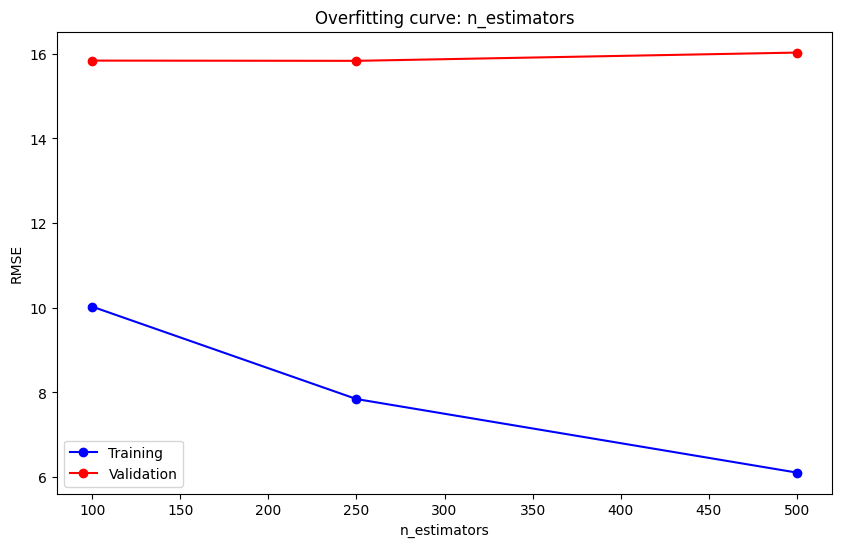

In [ ]:
%%time
test_param_and_plot(XGBRegressor, 'n_estimators', [100, 250, 500], **best_params)

CPU times: user 21.5 s, sys: 90.3 ms, total: 21.6 s
Wall time: 14 s


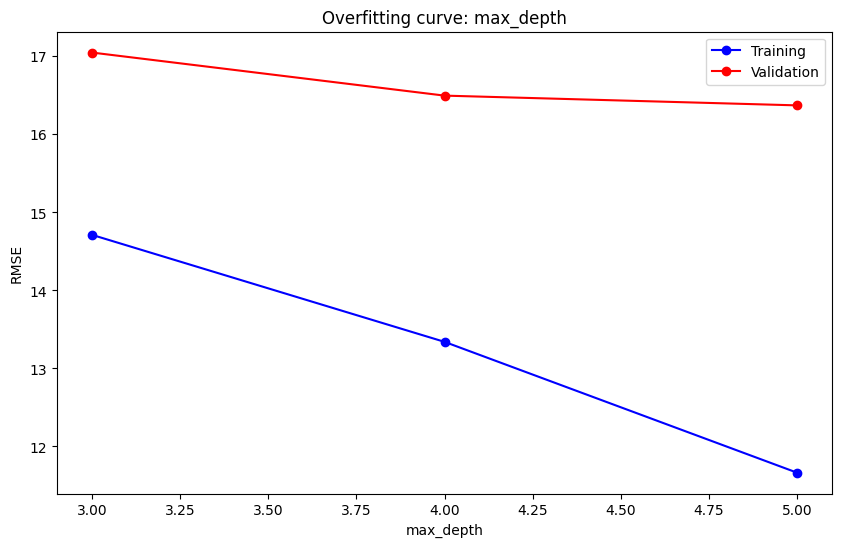

In [ ]:
%%time
test_param_and_plot(XGBRegressor, 'max_depth', [3, 4, 5], **best_params)

CPU times: user 29.8 s, sys: 101 ms, total: 29.9 s
Wall time: 18.4 s


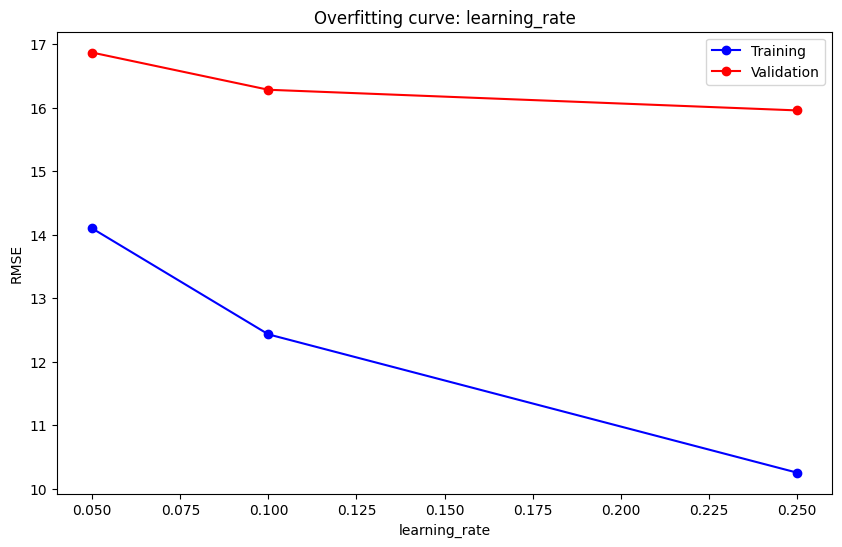

In [ ]:
%%time
test_param_and_plot(XGBRegressor, 'learning_rate', [0.05, 0.1, 0.25], **best_params)

### Other Parameters

In [ ]:
xgb_model_final = XGBRegressor(objective='reg:squarederror', n_jobs=-1, random_state=42,
                               n_estimators=500, max_depth=5, learning_rate=0.1,
                               subsample=0.8, colsample_bytree=0.8)

In [ ]:
%%time
xgb_model_final.fit(train_inputs, train_targets)

CPU times: user 22.1 s, sys: 80.9 ms, total: 22.2 s
Wall time: 12.2 s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=-1, num_parallel_tree=None, ...)

In [ ]:
evaluate(xgb_model_final)

(10.418968200683594,
 15.943745613098145,
 array([ 6.530516,  8.074234,  9.734117, ..., 11.633722,  9.062087,
        10.267519], dtype=float32),
 array([14.877447,  5.890325, 48.2188  , ...,  7.223251, 30.275099,
         8.533674], dtype=float32))

In [ ]:
predict_and_submit(xgb_model_final, 'xgb_tuned_submission.csv')

,key,fare_amount
0,2015-01-27 13:08:24.0000002,11.090381
1,2015-01-27 13:08:24.0000003,10.927958
2,2011-10-08 11:53:44.0000002,4.784460
3,2012-12-01 21:12:12.0000002,8.724652
4,2012-12-01 21:12:12.0000003,15.782324
...,...,...
9909,2015-05-10 12:37:51.0000002,8.711738
9910,2015-01-12 17:05:51.0000001,11.869908
9911,2015-04-19 20:44:15.0000001,54.236507
9912,2015-01-31 01:05:19.0000005,19.695951
